In [1]:
# 4years/review_2variable에서의 모델을 적용해보았으나 좋은 결과를 얻지 못함 -> 폐기

In [1]:
import json
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import regex as re
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt

import datetime
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

from keras.models import load_model

2022-12-01 19:08:30.809400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 19:08:30.912421: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-01 19:08:30.916946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 19:08:30.916961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [7]:
# 데이터 생성, 처리
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

def train_test_result(dir, stock, variable, window_size):
    #score data 뽑기
    score = pd.read_csv(dir)
    score.columns = ["Date", "Score"]
    
    #price data 뽑기
    price_data = yf.download([stock],start = '2017-01-01', end = "2022-05-01")
    price_data = price_data.reset_index()
    
    first_data = yf.download([stock],start = '2016-12-30', end = '2017-01-01')
    
    #Date를 datetime형식으로 변경
    score.Date = score.Date.apply(lambda x: time_conversion(x))
    
    #price data와 score data 결합
    price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","Open","Score"]]

    #뉴스가 없는 날은 즉, score가 없는 날은 중립의 의미로 0으로 처리
    price_data.Score[price_data.Score.isnull()]=0

    #전날 종가의 영향을 받으므로 전날 종가 변수를 생성
    price_data["before_close"] = 0
    price_data = price_data.reset_index(drop=True)
    for i in range(len(price_data)-1):
        price_data.before_close[i+1] = price_data.Close[i]
    
    price_data.before_close[0] = first_data["Close"][0]

    # minmaxscaler 사용
    price_data.columns = ["Close","Open","Score","before_close"]
    
    x = price_data[variable]
    y = price_data[["Close"]]
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    x = pd.DataFrame(scaler_x.fit_transform(x))
    y = pd.DataFrame(scaler_y.fit_transform(y))
    
    x.columns = variable
    y.columns = ["Close"]

    train_index = int(len(x)*0.7)

    train_x = x.iloc[0:train_index]
    test_x = x.iloc[train_index:len(x)]

    train_y = y.iloc[0:train_index]
    test_y = y.iloc[train_index:len(y)]

    train_x = train_x.to_numpy().reshape(train_x.shape[0],1,train_x.shape[1])
    train_y = train_y.to_numpy().reshape(train_y.shape[0],train_y.shape[1])
    test_x = test_x.to_numpy().reshape(test_x.shape[0],1,test_x.shape[1])
    test_y = test_y.to_numpy().reshape(test_y.shape[0],test_y.shape[1])
    
    #window size에 맞게 데이터 설정
    x = np.zeros(shape=(train_x.shape[0]-window_size+1,window_size,x.shape[1]))
    for i in range(train_x.shape[0]-window_size+1):
        x[i]=np.vstack((train_x[i:i+window_size]))

    y = train_y[window_size-1:train_x.shape[0]]

    x_t = np.zeros(shape=(test_x.shape[0]-window_size+1,window_size,x.shape[2]))
    for i in range(test_x.shape[0]-window_size+1):
        x_t[i]=np.vstack((test_x[i:i+window_size]))
    
    y_t = test_y[window_size-1:test_x.shape[0]]
    
    return x, y, x_t, y_t


# 3. Bi-LSTM

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/150


/tmp/ipykernel_31863/1364670182.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


12/12 [==============================] - 6s 185ms/step - loss: 0.0905 - mse: 0.0127 - mae: 0.0773 - val_loss: 0.0835 - val_mse: 0.0100 - val_mae: 0.0610
Epoch 2/150
12/12 [==============================] - 1s 103ms/step - loss: 0.0328 - mse: 0.0011 - mae: 0.0261 - val_loss: 0.0681 - val_mse: 0.0066 - val_mae: 0.0504
Epoch 3/150
12/12 [==============================] - 1s 106ms/step - loss: 0.0284 - mse: 8.1388e-04 - mae: 0.0225 - val_loss: 0.0628 - val_mse: 0.0053 - val_mae: 0.0475
Epoch 4/150
12/12 [==============================] - 1s 104ms/step - loss: 0.0257 - mse: 6.7230e-04 - mae: 0.0196 - val_loss: 0.0577 - val_mse: 0.0042 - val_mae: 0.0427
Epoch 5/150
12/12 [==============================] - 1s 105ms/step - loss: 0.0247 - mse: 6.1283e-04 - mae: 0.0190 - val_loss: 0.0517 - val_mse: 0.0033 - val_mae: 0.0385
Epoch 6/150
12/12 [==============================] - 1s 102ms/step - loss: 0.0212 - mse: 4.6312e-04 - mae: 0.0159 - val_loss: 0.0471 - val_mse: 0.0027 - val_mae: 0.0360
Epoch 

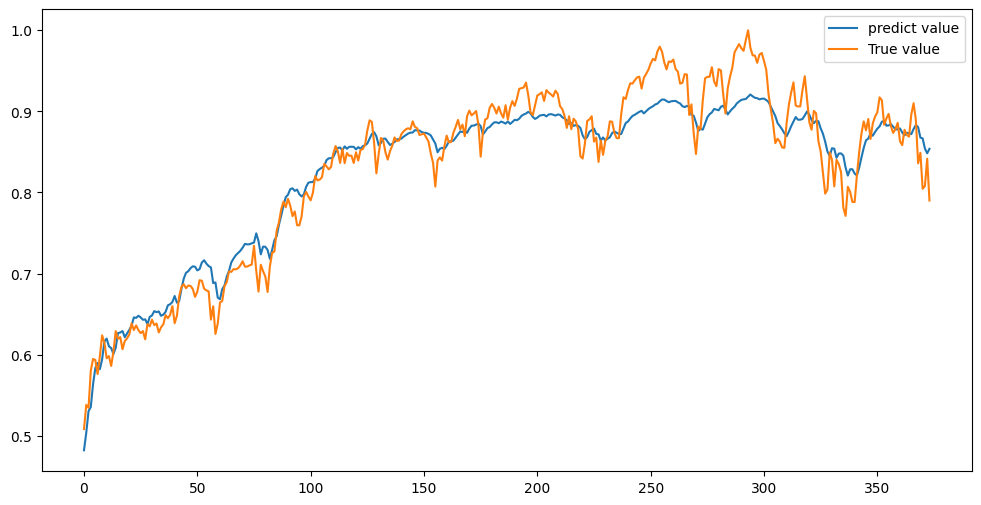

In [56]:
dir = "/home/whfhrs3260/csv_data/category_selected_score.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
adam = optimizers.Adam(learning_rate=0.0012)
bi_lstm_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = bi_lstm_model.fit(x, y, epochs=150, batch_size=64, validation_split=0.2)
    
bi_lstm_pred = bi_lstm_model.evaluate(x_t, y_t)

In [57]:
bi_lstm_pred

([0.02646435983479023, 0.0007935658213682473, 0.022046338766813278],
 <matplotlib.legend.Legend at 0x7f609ff94820>)

In [58]:
dir_model = "/home/whfhrs3260/model/"
#bi_lstm_model.save(dir_model + 'bi_lstm_128_64_window30_selected_category.h5')

# 4. LSTM

In [78]:
dir = "/home/whfhrs3260/csv_data/catagory_selected_score.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_1_model = Sequential()
lstm_1_model.add(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
lstm_1_model.add(Dropout(0.2))
lstm_1_model.add((LSTM(64)))
lstm_1_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
adam = optimizers.Adam(learning_rate=0.0012)
lstm_1_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = lstm_1_model.fit(x, y, epochs=150, batch_size=64, validation_split=0.2)
    
lstm_1_pred = lstm_1_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_31863/47792970.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


Epoch 1/150



KeyboardInterrupt



In [74]:
lstm_1_pred

([0.0678318589925766, 0.005516699980944395, 0.06494861096143723],
 <matplotlib.legend.Legend at 0x7f6077a57dc0>)

In [75]:
#lstm_1_model.save(dir_model + 'lstm_128_64_window30_selected_category.h5')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_31863/4191868945.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


Epoch 1/40
6/6 [==============================] - 3s 116ms/step - loss: 0.3283 - mse: 0.1078 - mae: 0.3053 - val_loss: 0.4059 - val_mse: 0.1655 - val_mae: 0.3848
Epoch 2/40
6/6 [==============================] - 0s 14ms/step - loss: 0.2999 - mse: 0.0901 - mae: 0.2751 - val_loss: 0.3740 - val_mse: 0.1405 - val_mae: 0.3519
Epoch 3/40
6/6 [==============================] - 0s 13ms/step - loss: 0.2684 - mse: 0.0722 - mae: 0.2411 - val_loss: 0.3369 - val_mse: 0.1141 - val_mae: 0.3140
Epoch 4/40
6/6 [==============================] - 0s 15ms/step - loss: 0.2318 - mse: 0.0538 - mae: 0.2031 - val_loss: 0.2927 - val_mse: 0.0861 - val_mae: 0.2689
Epoch 5/40
6/6 [==============================] - 0s 15ms/step - loss: 0.1895 - mse: 0.0361 - mae: 0.1637 - val_loss: 0.2403 - val_mse: 0.0580 - val_mae: 0.2169
Epoch 6/40
6/6 [==============================] - 0s 15ms/step - loss: 0.1448 - mse: 0.0211 - mae: 0.1279 - val_loss: 0.1830 - val_mse: 0.0336 - val_mae: 0.1596
Epoch 7/40
6/6 [=================

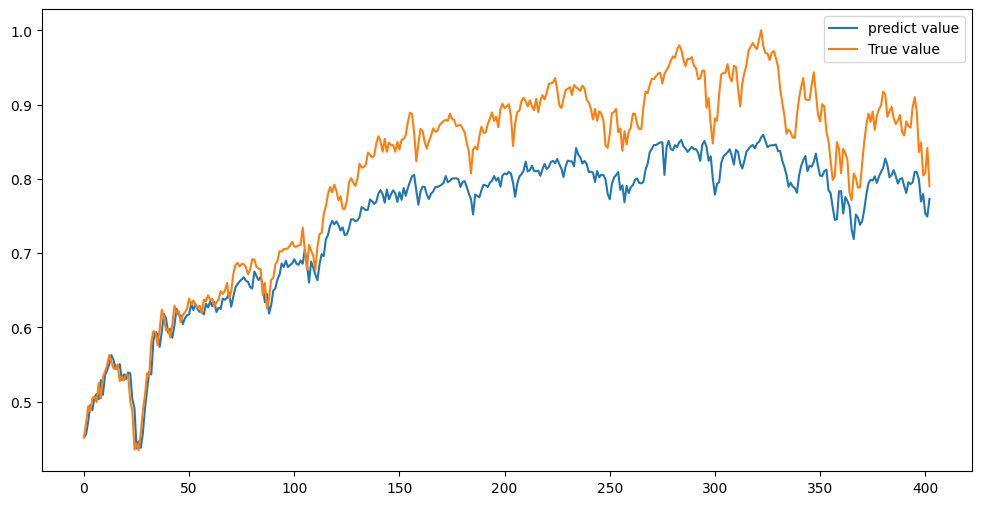

In [84]:
dir = "/home/whfhrs3260/csv_data/category_selected_score.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_2_model = Sequential()
lstm_2_model.add(LSTM(50, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
lstm_2_model.add((LSTM(50)))
lstm_2_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
lstm_2_model.compile(optimizer="adam", loss = root_mean_squared_error, metrics=['mse',"mae"])
history = lstm_2_model.fit(x, y, epochs=40, batch_size=128, validation_split=0.2)
    
lstm_2_pred = lstm_2_model.evaluate(x_t, y_t)

In [86]:
lstm_2_pred

([0.06701523065567017, 0.005529592279344797, 0.06454502046108246],
 <matplotlib.legend.Legend at 0x7f605bfd9a60>)

In [87]:
#lstm_2_model.save(dir_model + 'lstm_50_50_window1_selected_category.h5')

# 5. GRU

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_31863/2315571412.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


Epoch 1/200


/home/whfhrs3260/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6/6 [==============================] - 3s 205ms/step - loss: 0.2415 - mse: 0.0707 - mae: 0.2187 - val_loss: 0.1115 - val_mse: 0.0148 - val_mae: 0.0907
Epoch 2/200
6/6 [==============================] - 1s 104ms/step - loss: 0.1399 - mse: 0.0199 - mae: 0.1143 - val_loss: 0.1042 - val_mse: 0.0109 - val_mae: 0.0888
Epoch 3/200
6/6 [==============================] - 1s 107ms/step - loss: 0.1010 - mse: 0.0102 - mae: 0.0839 - val_loss: 0.1238 - val_mse: 0.0154 - val_mae: 0.1095
Epoch 4/200
6/6 [==============================] - 1s 107ms/step - loss: 0.0758 - mse: 0.0059 - mae: 0.0636 - val_loss: 0.0600 - val_mse: 0.0042 - val_mae: 0.0437
Epoch 5/200
6/6 [==============================] - 1s 107ms/step - loss: 0.0572 - mse: 0.0033 - mae: 0.0462 - val_loss: 0.0689 - val_mse: 0.0047 - val_mae: 0.0616
Epoch 6/200
6/6 [==============================] - 1s 109ms/step - loss: 0.0508 - mse: 0.0026 - mae: 0.0401 - val_loss: 0.0533 - val_mse: 0.0031 - val_mae: 0.0379
Epoch 7/200
6/6 [=================

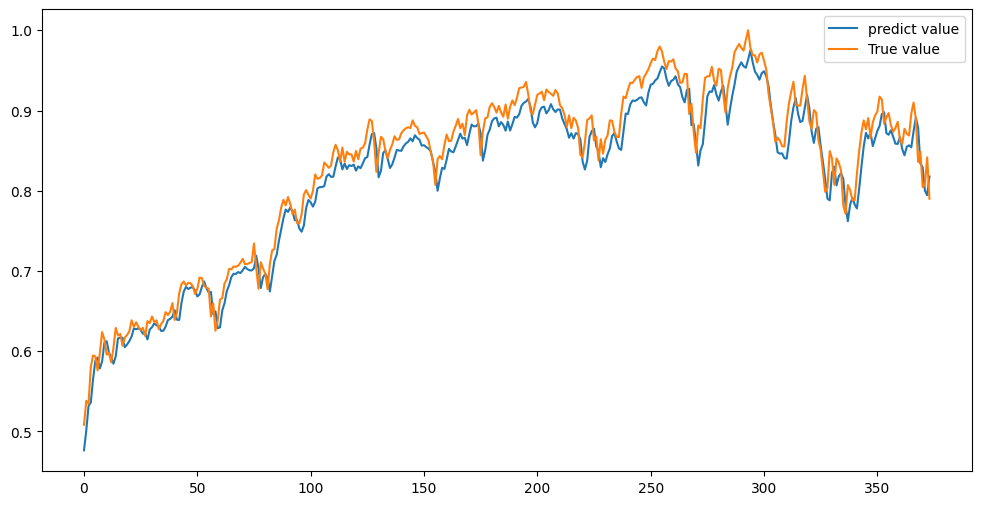

In [97]:
dir = "/home/whfhrs3260/csv_data/category_selected_score.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

gru_model = Sequential()
gru_model.add(GRU(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32))
gru_model.add(Dense(1))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
adam = optimizers.Adam(lr=0.0005)
gru_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = gru_model.fit(x, y, epochs=200, batch_size=128, validation_split=0.2)
    
gru_pred = gru_model.evaluate(x_t, y_t)

In [98]:
gru_pred

([0.02253393642604351, 0.0005232053226791322, 0.01926668919622898],
 <matplotlib.legend.Legend at 0x7f5fc42e4bb0>)

In [94]:
#gru_model.save(dir_model + 'gru_128_64_32_window30_selected_category.h5')

# Prediction

In [19]:
from keras.models import load_model

# Bi-LSTM 
dir_model = "/home/whfhrs3260/model/"
dir = "/home/whfhrs3260/csv_data/category_selected_score.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

bi_lstm_model = load_model(dir_model + 'bi_lstm_128_64_window30_selected_category.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
bi_lstm_pred = bi_lstm_model.predict(x_t)
bi_lstm_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_257966/3841764231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


12/12 [==============================] - 1s 25ms/step - loss: 0.0265 - mse: 7.9357e-04 - mae: 0.0220


[0.02646435983479023, 0.0007935658213682473, 0.022046338766813278]

In [20]:
# LSTM_1 
dir = "/home/whfhrs3260/csv_data/category_selected_score.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)
lstm_1_model = load_model(dir_model + 'lstm_128_64_window30_selected_category.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
lstm_1_pred = lstm_1_model.predict(x_t)
lstm_1_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_257966/3841764231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


12/12 [==============================] - 1s 20ms/step - loss: 0.0678 - mse: 0.0055 - mae: 0.0649


[0.0678318589925766, 0.005516699980944395, 0.06494861096143723]

In [21]:
# LSTM_2
dir = "/home/whfhrs3260/csv_data/category_selected_score.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_2_model = load_model(dir_model + 'lstm_50_50_window1_selected_category.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
lstm_2_pred = lstm_2_model.predict(x_t)
lstm_2_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_257966/3841764231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


13/13 [==============================] - 1s 3ms/step - loss: 0.0670 - mse: 0.0055 - mae: 0.0645


[0.06701523065567017, 0.005529592279344797, 0.06454502046108246]

In [22]:
# GRU
dir = "/home/whfhrs3260/csv_data/category_selected_score.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

gru_model = load_model(dir_model + 'gru_128_64_32_window30_selected_category.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
gru_pred = gru_model.predict(x_t)
gru_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_257966/3841764231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


12/12 [==============================] - 1s 18ms/step - loss: 0.0186 - mse: 3.5954e-04 - mae: 0.0153


[0.01864675059914589, 0.0003595411835703999, 0.015333235263824463]

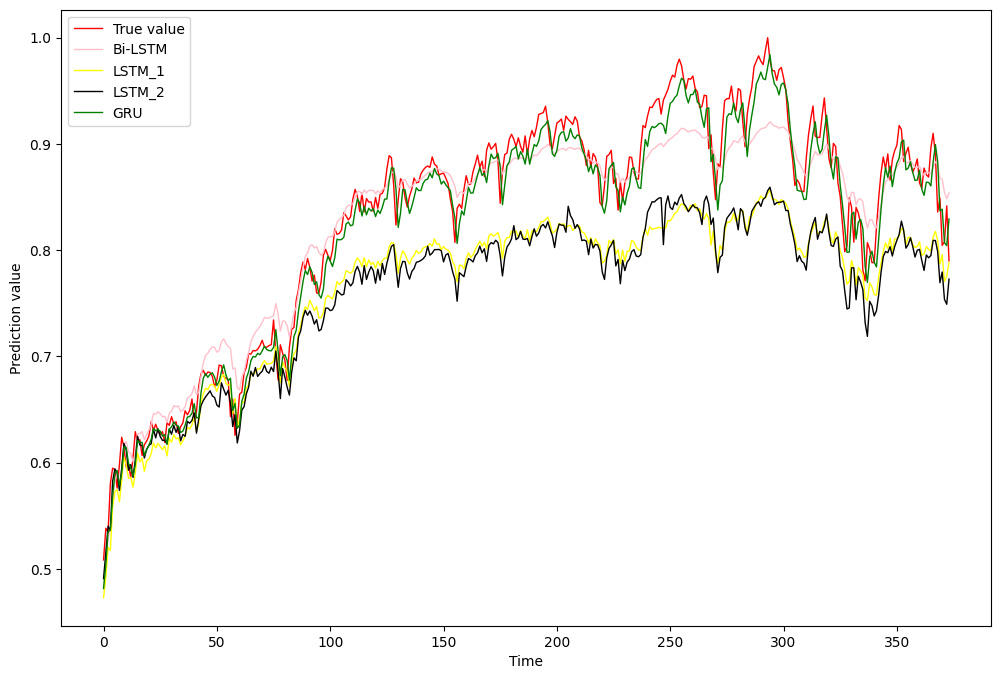

In [18]:
# ARIMA, SVR을 제외한 모델 그래프
plt.figure(figsize=(12,8))
plt.plot(y_t, label = "True value", color = "red", linewidth=1)
plt.plot(bi_lstm_pred, label = "Bi-LSTM", color = "pink", linewidth=1)
plt.plot(lstm_1_pred, label = "LSTM_1", color = "yellow", linewidth=1)
plt.plot(lstm_2_pred[29:len(lstm_2_pred)], label = "LSTM_2", color = "black", linewidth=1)
plt.plot(gru_pred, label = "GRU", color = "green", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Prediction value")
plt.legend()